In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tensorflow.keras.metrics import AUC, Precision, Recall

from art.utils import load_dataset
from art.estimators.classification import SklearnClassifier
from art.estimators.classification import KerasClassifier
import tensorflow as tf 
from tensorflow.python.framework.ops import disable_eager_execution

# i have no idea why this is necessary but it is 
disable_eager_execution()

In [2]:
#helpers to flatten/unflatten images
def img_to_vector(x):
    return np.reshape(x, (x.shape[0], -1))

def vector_to_img(nbr_samples, x):
    return x.reshape(nbr_samples, 32, 32, 3)

In [3]:
# Load data and perform preprocessing
use_art_loader = False
if use_art_loader:
    # Load in the data
    (x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))

    # the _sk versions are modified for using sklearn
    # x is flattened and y is changed from one-hot encoded to a single value
    x_train_sk = np.reshape(x_train, (x_train.shape[0], -1))
    x_test_sk = np.reshape(x_test, (x_test.shape[0], -1))
    y_train_sk = np.argmax(y_train, axis=1)
    y_test_sk = np.argmax(y_test, axis=1)

    # _small versions contain only a subset of x and y
    # Used for SVC, otherwise it is very slow
    x_train_small, y_train_small = x_train[:20000], y_train[:20000]
    x_test_small, y_test_small = x_test[:4000], y_test[:4000]

    # the _sk versions are modified for using sklearn
    # x is flattened and y is changed from one-hot encoded to a single value
    x_train_small_sk = np.reshape(x_train_small, (x_train_small.shape[0], -1))
    x_test_small_sk = np.reshape(x_test_small, (x_test_small.shape[0], -1))
    y_train_small_sk = np.argmax(y_train_small, axis=1)
    y_test_small_sk = np.argmax(y_test_small, axis=1)
else:
    # Use TensorFlow cifar-10 data loader
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    random_train_split = False
    if random_train_split:
        # Combine train/test data and resplit randomly
        print(type(x_train))
        x = np.concatenate((x_train, x_test))
        y = np.concatenate((y_train, y_test))
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=3000)
    # Convert y from column vector to array
#    y_train = y_train.ravel()
#    y_test = y_test.ravel()
    
    # Temporarily reduct data sizes
    x_train = x_train[:20000]
    y_train = y_train[:20000]
    x_test = x_test[:5000]
    y_test = y_test[:5000]
    #normalize data 
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #pixels have values between 0 and 255
    x_train  /= 255
    x_test /= 255

    # the _sk versions are modified for using sklearn
    # x is flattened 
    x_train_sk = np.reshape(x_train, (x_train.shape[0], -1))
    x_test_sk = np.reshape(x_test, (x_test.shape[0], -1))
    # Temporarily set the _sk versions for y
    # Will get rid of this when confirm no longer needed
    y_train_sk = y_train.ravel()
    y_test_sk = y_test.ravel()
    
    # _small versions contain only a subset of x and y
    # Used for SVC, otherwise it is very slow
    x_train_small_sk, y_train_small = x_train_sk[:20000], y_train[:20000]
    x_test_small_sk, y_test_small = x_test_sk[:4000], y_test[:4000]
    y_train_small_sk = y_train_small.ravel()
    y_test_small_sk = y_test_small.ravel()
    #For sklearn models, y should remain as the class ordinal
#    y_train_sk = y_train
#    y_test_sk = y_test
    
    # For CNN models, y should be one-hot encoded, ie, a list of binary values
#    enc = OneHotEncoder(sparse=False, dtype='int8')
#    y_train = enc.fit_transform(y_train)
#    y_test = enc.fit_transform(y_test)
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10, dtype='int8')
    y_test = tf.keras.utils.to_categorical(y_test , num_classes=10, dtype='int8')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

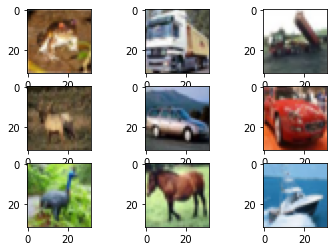

In [4]:
%matplotlib inline

# display a subset of images
def display_img(count, x_train):
    for i in range(count):
        plt.subplot(330 + 1 + i)
        # plot raw pixel data
        plt.imshow(x_train[i])
    # show the figure
    plt.show()

display_img(9, x_train)

In [49]:
# Saves a model to a file using pickle
def save_model(model, name):
    filename = name + '-model.pkl'
    print(f'Saving {filename}')
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
       pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)

In [50]:
# Loads a model from a pickle file
def load_model(name):
    filename = name + '-model.pkl'
    with open(filename, 'rb') as inp:
        model = pickle.load(inp)
        return model    

In [51]:
# Saves a model to a file using pickle
def save_images(imgs, name):
    filename = name + '-images.pkl'
    print(f'Saving {filename}')
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
       pickle.dump(imgs, outp, pickle.HIGHEST_PROTOCOL)

In [52]:
# Loads adversarialimages from a pickle file
def load_images(name):
    filename = name + '-images.pkl'
    with open(filename, 'rb') as inp:
        images = pickle.load(inp)
        return images 

In [5]:
from sklearn.decomposition import PCA
# Run PCA to reduce number of features
pca = PCA(.90) # number of components to cover 90%

x_train_pca = pca.fit_transform(x_train_sk)
x_test_pca = pca.transform(x_test_sk)

print(x_train_pca.shape, pca.components_.shape)

(20000, 98) (98, 3072)


In [6]:
pca_small = PCA(pca.n_components_) # match nbr components in full pca set
x_train_small_pca = pca_small.fit_transform(x_train_small_sk)
x_test_small_pca = pca_small.transform(x_test_small_sk)

print(x_train_small_pca.shape, pca_small.components_.shape)


(20000, 98) (98, 3072)


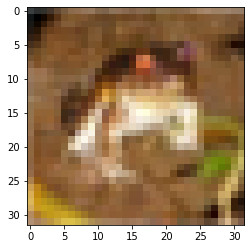

In [7]:
# Example of one original training image
plt.imshow(x_train_sk[0].reshape(32,32,3))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


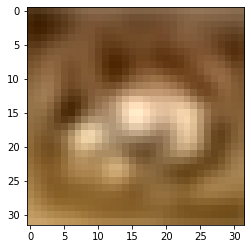

In [8]:
# Example of image using inverse transform of PCA data
# Still semi-recognizable
x_train_pca_inv = pca.inverse_transform(x_train_pca)
plt.imshow(x_train_pca_inv[0].reshape(32, 32, 3))
plt.show()

p=0.4
  Nbr components: 2
p=0.5
  Nbr components: 4
p=0.6
  Nbr components: 8
p=0.7
  Nbr components: 14
p=0.8
  Nbr components: 32
p=0.9
  Nbr components: 98
p=0.95
  Nbr components: 214


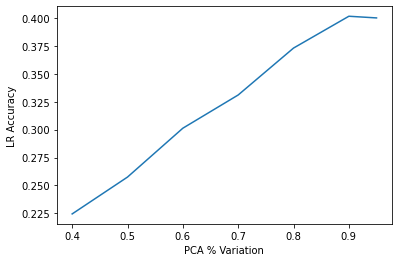

In [9]:
# See how number of components affects accuracy
y_acc = []
x_acc = []
for p in [.4, .5, .6, .7, .8, .9, .95]:
    print(f'p={p}')
    pca_p = PCA(p)
    x_train_small_pcap = pca_p.fit_transform(x_train_small_sk)
    x_test_small_pcap = pca_p.transform(x_test_small_sk)
    print(f'  Nbr components: {pca_p.n_components_}')
    clf_lr_p = LogisticRegression(solver='saga', multi_class='multinomial', tol=0.01)
    clf_lr_p.fit(x_train_small_pcap, y_train_small_sk)
    predict = clf_lr_p.predict(x_test_small_pcap)
    accuracy = metrics.accuracy_score(y_test_small_sk, predict)
    x_acc.append(p)
    y_acc.append(accuracy)
plt.plot(x_acc, y_acc)
plt.xlabel('PCA % Variation')
plt.ylabel('LR Accuracy')
plt.show()   

In [10]:
# Look at confusion matrix
# Helper to plot a confusion matrix for a classifier
def clf_cm(clf, X_test, y_test, title):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    pred = clf.predict(X_test)
    if y_test.ndim > 1:
        # one-hot encoded y's and predictions - collapse to 1 dimension
        y_test = np.argmax(y_test, axis=1)
        pred = np.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, pred) * 100 / X_test.shape[0]
    cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title + ' (percentages)')
    cm_plt.plot(ax=ax, xticks_rotation=45)
    plt.grid(False)

In [11]:
# Compute metrics for a model. Returns results in a dictionary
def model_metrics(model, X_test, y_test):
    pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, pred)
    y_prob = model.predict_proba(X_test)
    macro_roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    # Accumulate metrics
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_test, pred, average='macro')
    results = {'Accuracy': accuracy, 'Precision': precision,
               'Recall': recall, 'F1': f1, 'AUC': macro_roc_auc}

    return results

In [12]:
# Plot multi-class ROC curve just using multi-class predictions
# The is based on the source code for the yellowbrick package
# https://github.com/DistrictDataLabs/yellowbrick/blob/develop/yellowbrick/classifier/rocauc.py
# The yellowbrick code seemed to only work with an sklearn classifier, so this is an
# adaptation to only require the true y values, and the predicted probabilities.
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def multiclass_roc_plot(y, y_pred, title):
    # If y is not one-hot encoded, take care of that.
    if y.ndim == 1:
        y = tf.keras.utils.to_categorical(y, num_classes=10, dtype='int8')
    plt.figure(figsize = (10,7))

    # Save fpr, trp, roc per class in lists so that macro averages can be computed
    n_classes = len(classes)
    fpr = [None] * n_classes
    tpr = [None] * n_classes
    roc_auc = [None] * n_classes
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} AUC = {roc_auc[i]:0.2f}')
       
    # Compute macro average scores
    # Next chunk comes from yellowbrick library
    # Gather all FPRs
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    avg_tpr = np.zeros_like(all_fpr)

    # Compute the averages per class
    for i in range(n_classes):
        avg_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finalize the average
    avg_tpr /= n_classes

    # Draw the macro average ROC curve and compute macro average AUC
    fpr_macro = all_fpr
    tpr_macro = avg_tpr
    roc_auc_macro = metrics.auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro, tpr_macro, linestyle=':', lw=3, label=f'Macro average AUC = {roc_auc_macro:0.2f}')
   
    plt.legend(loc="lower right")
    plt.title(title)
    plt.plot([0, 1], [0, 1], linestyle=":", c='black')
    plt.grid(False)
    plt.show()

In [13]:
def roc_multi2(clf, X_train, y_train, X_test, y_test):
    classifier = OneVsRestClassifier(clf)
    y_pred = classifier.fit(X_train, y_train).predict_proba(X_test)
    multiclass_roc_plot(y_test, y_pred, 'ROC')

In [14]:
from sklearn.model_selection import GridSearchCV
# Helper to run GridSearchCV
def runGridSearch(estimator, parameters, x_train, y_train, x_test, y_test):
    print(f'*****Estimator: {estimator} ********')
    gscv = GridSearchCV(estimator=estimator, param_grid=parameters, verbose=4, n_jobs=4, refit=True)
    gscv.fit(x_train, y_train)
    df = pd.DataFrame(gscv.cv_results_)
    display(df)
    print(gscv.best_estimator_)
    print(f'   Best train score: {gscv.best_score_}')
    best_est = gscv.best_estimator_
    predict = best_est.predict(x_test)
    # save model
    with open(type(best_est).__name__ + '.pkl', 'wb') as outp:  # Overwrites any existing file.
       pickle.dump((x_test, y_test), outp, pickle.HIGHEST_PROTOCOL)
    print(f'   test accuracy={metrics.accuracy_score(y_test, predict)}')  
    print(f'   Best params: {gscv.best_params_}')
    return best_est

In [15]:
# Create dictionary to hold results from all trials
# Key is a model abbreviation (eg, DT for DecisionTree) followed by a string indicating
# options (eg, 'df' for DeepFool attack on the model)
# Each value is a dictionary with keys identifying the metric or other piece of information
all_results = {}

In [16]:
# Run GridSearchCV on logistic Regression options
from sklearn.linear_model import LogisticRegression
lr_parameters = {'penalty': ('l2', 'none'), 'tol': (1.0e-2, 1.0e-4)}
lr_model = LogisticRegression(solver='saga', multi_class='multinomial')
lr_clf = runGridSearch(lr_model, lr_parameters, x_train_sk, y_train_sk, x_test_sk, y_test_sk)

*****Estimator: LogisticRegression(multi_class='multinomial', solver='saga') ********
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,112.311065,5.796929,0.055450,0.023184,l2,0.01,"{'penalty': 'l2', 'tol': 0.01}",0.39575,0.39450,0.38875,0.38075,0.38475,0.38890,0.005691,1
1,207.608839,3.400691,0.013780,0.001372,l2,0.0001,"{'penalty': 'l2', 'tol': 0.0001}",0.38475,0.38725,0.37750,0.37500,0.37725,0.38035,0.004761,3
2,106.854072,5.680818,0.011413,0.000302,none,0.01,"{'penalty': 'none', 'tol': 0.01}",0.39500,0.39325,0.38450,0.38050,0.38375,0.38740,0.005680,2
3,193.271759,5.093353,0.013384,0.001131,none,0.0001,"{'penalty': 'none', 'tol': 0.0001}",0.38375,0.38575,0.37600,0.37500,0.37675,0.37945,0.004409,4


LogisticRegression(multi_class='multinomial', solver='saga', tol=0.01)
   Best train score: 0.38889999999999997
   test accuracy=0.407
   Best params: {'penalty': 'l2', 'tol': 0.01}


In [17]:
lr_model.fit(x_train_sk, y_train_sk)

C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(multi_class='multinomial', solver='saga')

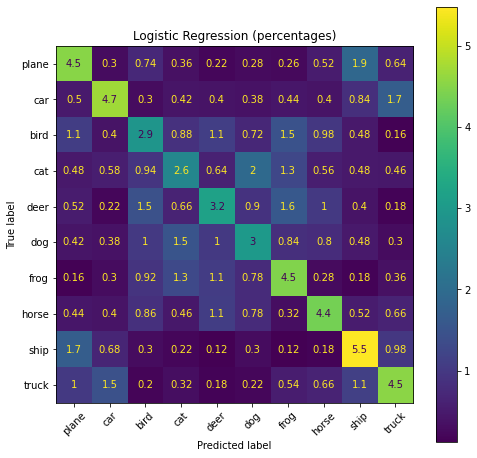

In [18]:
clf_cm(lr_model, x_test_sk, y_test_sk, 'Logistic Regression')

In [19]:
# Accumulate metrics
lr_results = model_metrics(lr_clf, x_test_sk, y_test_sk)
all_results['LogisticRegression'] = lr_results
lr_results

{'Accuracy': 0.407,
 'Precision': 0.4031334795393898,
 'Recall': 0.4070953591524834,
 'F1': 0.4039005933205094,
 'AUC': 0.8168445245290507}

In [20]:
print(model_metrics(lr_model, x_test_sk, y_test_sk))

{'Accuracy': 0.3976, 'Precision': 0.39441370932095726, 'Recall': 0.3976866710981941, 'F1': 0.3950289520140665, 'AUC': 0.8120868977239685}


C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

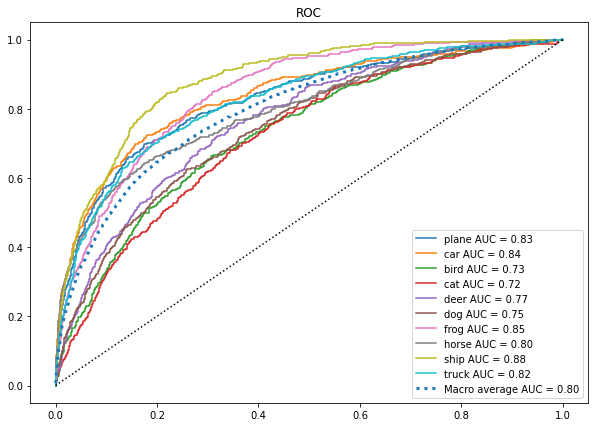

In [21]:
roc_multi2(lr_model, x_train_sk, y_train_sk, x_test_sk, y_test_sk)

In [23]:
# Run GridSearchCV on decision tree options
dt_parameters = {'max_depth': (10, 20, 50), 'max_features': ('auto', None)}
dt_clf = runGridSearch(DecisionTreeClassifier(), dt_parameters, x_train_sk, y_train_sk, x_test_sk, y_test_sk)

*****Estimator: DecisionTreeClassifier() ********
Fitting 5 folds for each of 6 candidates, totalling 30 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.597582,0.012593,0.015674,0.004976,10,auto,"{'max_depth': 10, 'max_features': 'auto'}",0.27225,0.26950,0.25925,0.26225,0.27075,0.26680,0.005105,2
1,23.458221,0.155599,0.010715,0.001278,10,None,"{'max_depth': 10, 'max_features': None}",0.27450,0.28450,0.26200,0.27350,0.27500,0.27390,0.007151,1
2,0.799651,0.009018,0.011507,0.001944,20,auto,"{'max_depth': 20, 'max_features': 'auto'}",0.24725,0.23950,0.23350,0.23900,0.24225,0.24030,0.004487,5
3,34.146522,0.280361,0.010218,0.000243,20,None,"{'max_depth': 20, 'max_features': None}",0.24925,0.24850,0.24200,0.25550,0.24950,0.24895,0.004285,3
4,0.787253,0.006913,0.010316,0.000578,50,auto,"{'max_depth': 50, 'max_features': 'auto'}",0.23625,0.24425,0.23975,0.22825,0.22775,0.23525,0.006442,6
5,34.452061,0.625446,0.010615,0.000506,50,None,"{'max_depth': 50, 'max_features': None}",0.24675,0.24600,0.23550,0.24700,0.24575,0.24420,0.004374,4


DecisionTreeClassifier(max_depth=10)
   Best train score: 0.2739
   test accuracy=0.2884
   Best params: {'max_depth': 10, 'max_features': None}


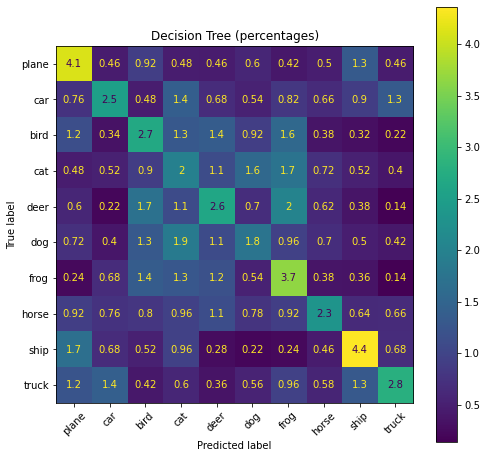

In [24]:
clf_cm(dt_clf, x_test_sk, y_test_sk, 'Decision Tree')

In [25]:
dt_results = model_metrics(dt_clf, x_test_sk, y_test_sk)
# Accumulate metrics
all_results['DecisionTree'] = dt_results
print('DecisionTree Metrics', dt_results)

DecisionTree Metrics {'Accuracy': 0.2884, 'Precision': 0.29260240294145123, 'Recall': 0.2885729275451839, 'F1': 0.28712717192662884, 'AUC': 0.6737367255242999}


In [26]:
# Run GridSearchCV on AdaBoost options
ab_parameters = {'base_estimator': (DecisionTreeClassifier(), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4)),
                 'n_estimators': (100, 200, 300)}
ab_clf = runGridSearch(AdaBoostClassifier(), ab_parameters, x_train_sk, y_train_sk, x_test_sk, y_test_sk)

*****Estimator: AdaBoostClassifier() ********
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,35.886294,0.673832,0.035416,0.006342,DecisionTreeClassifier(),100,"{'base_estimator': DecisionTreeClassifier(), '...",0.24700,0.24600,0.23450,0.25750,0.24600,0.24620,0.007284,8
1,36.833753,0.523892,0.029264,0.000700,DecisionTreeClassifier(),200,"{'base_estimator': DecisionTreeClassifier(), '...",0.24675,0.25675,0.23775,0.25500,0.24700,0.24865,0.006798,7
2,36.458280,0.681290,0.031943,0.004284,DecisionTreeClassifier(),300,"{'base_estimator': DecisionTreeClassifier(), '...",0.24600,0.24925,0.23750,0.24975,0.24125,0.24475,0.004725,9
3,442.113159,1.133121,0.958768,0.015600,DecisionTreeClassifier(max_depth=2),100,{'base_estimator': DecisionTreeClassifier(max_...,0.33825,0.33425,0.35550,0.32775,0.33775,0.33870,0.009198,3
4,884.681745,20.589675,2.024371,0.266558,DecisionTreeClassifier(max_depth=2),200,{'base_estimator': DecisionTreeClassifier(max_...,0.35450,0.34600,0.36250,0.33350,0.34200,0.34770,0.010023,2
5,1560.047722,74.525484,3.813049,0.098697,DecisionTreeClassifier(max_depth=2),300,{'base_estimator': DecisionTreeClassifier(max_...,0.35475,0.34225,0.36925,0.33625,0.34750,0.35000,0.011389,1
6,1085.643180,22.521426,1.176909,0.151235,DecisionTreeClassifier(max_depth=4),100,{'base_estimator': DecisionTreeClassifier(max_...,0.31600,0.32000,0.30650,0.29825,0.32125,0.31240,0.008764,4
7,1779.512141,62.726161,1.883807,0.028604,DecisionTreeClassifier(max_depth=4),200,{'base_estimator': DecisionTreeClassifier(max_...,0.30400,0.30925,0.30525,0.30550,0.31050,0.30690,0.002513,5
8,2551.720928,50.829485,2.726808,0.081118,DecisionTreeClassifier(max_depth=4),300,{'base_estimator': DecisionTreeClassifier(max_...,0.31450,0.31300,0.29700,0.29925,0.30425,0.30560,0.007072,6


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300)
   Best train score: 0.35
   test accuracy=0.3744
   Best params: {'base_estimator': DecisionTreeClassifier(max_depth=2), 'n_estimators': 300}


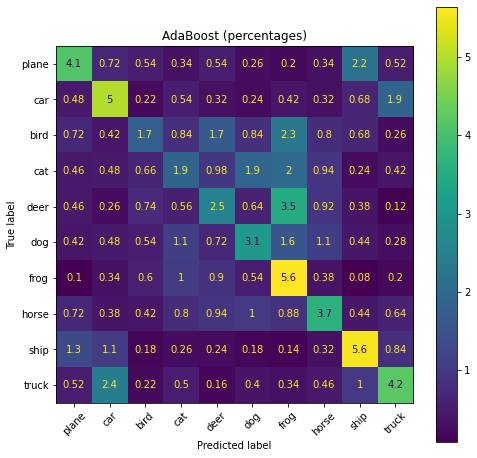

In [28]:
clf_cm(ab_clf, x_test_sk, y_test_sk, 'AdaBoost')

In [29]:
# Accumulate metrics
ab_results = model_metrics(ab_clf, x_test_sk, y_test_sk)
all_results['AdaBoost'] = ab_results
ab_results

{'Accuracy': 0.3744,
 'Precision': 0.3684696787801367,
 'Recall': 0.374923260319232,
 'F1': 0.3656771911678508,
 'AUC': 0.7801915684519489}

In [30]:
# Run GridSearchCV on Random Forest options
rf_parameters = {'n_estimators': (25,50,100), 'max_depth':(10,50,100)}
rf_clf = runGridSearch(RandomForestClassifier(n_jobs=4), rf_parameters, x_train_sk, y_train_sk, x_test_sk, y_test_sk)

*****Estimator: RandomForestClassifier(n_jobs=4) ********
Fitting 5 folds for each of 9 candidates, totalling 45 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.222909,0.012143,0.034224,0.005305,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.40025,0.38675,0.39050,0.38250,0.37375,0.38675,0.008756,7
1,6.052185,0.169105,0.060512,0.009183,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.40775,0.40150,0.39825,0.39075,0.39975,0.39960,0.005481,6
2,10.983126,0.050159,0.092455,0.009182,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.41875,0.41300,0.41200,0.40300,0.39950,0.40925,0.007014,5
3,4.649305,0.077947,0.041962,0.002275,50,25,"{'max_depth': 50, 'n_estimators': 25}",0.39100,0.38400,0.38750,0.38325,0.38400,0.38595,0.002926,8
4,9.335811,0.110622,0.080055,0.013726,50,50,"{'max_depth': 50, 'n_estimators': 50}",0.41825,0.41575,0.41225,0.41225,0.40425,0.41255,0.004729,3
5,17.395017,0.208745,0.118643,0.004408,50,100,"{'max_depth': 50, 'n_estimators': 100}",0.44250,0.43175,0.43450,0.43300,0.42150,0.43265,0.006719,1
6,4.857725,0.168899,0.043351,0.004121,100,25,"{'max_depth': 100, 'n_estimators': 25}",0.39500,0.37950,0.39125,0.37625,0.37400,0.38320,0.008375,9
7,8.826121,0.121396,0.067555,0.002537,100,50,"{'max_depth': 100, 'n_estimators': 50}",0.41975,0.42575,0.40900,0.40450,0.39825,0.41145,0.010019,4
8,16.045601,1.688242,0.107035,0.016467,100,100,"{'max_depth': 100, 'n_estimators': 100}",0.44200,0.43050,0.42700,0.42775,0.42175,0.42980,0.006726,2


RandomForestClassifier(max_depth=50, n_jobs=4)
   Best train score: 0.4326499999999999
   test accuracy=0.45
   Best params: {'max_depth': 50, 'n_estimators': 100}


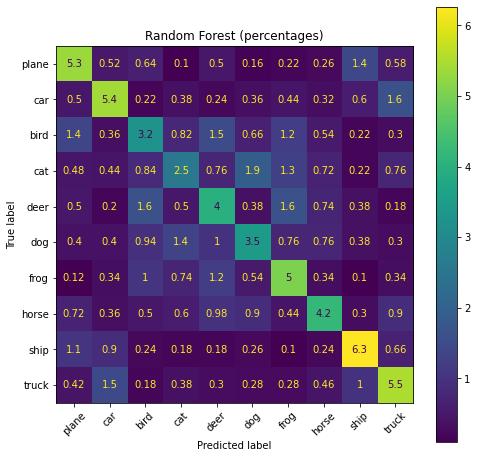

In [31]:
clf_cm(rf_clf, x_test_sk, y_test_sk, 'Random Forest')

In [32]:
# Accumulate metrics
rf_results = model_metrics(rf_clf, x_test_sk, y_test_sk)
all_results['RandomForest'] = rf_results
rf_results

{'Accuracy': 0.45,
 'Precision': 0.44490769619436665,
 'Recall': 0.44992568005935274,
 'F1': 0.44589034264925614,
 'AUC': 0.8421129745816651}

In [33]:
# Try SVC on the PCA data (warning - this is still slow!!)
clf_svc = SVC(C=4, kernel='linear', verbose=2)
#clf_svc.fit(x_train_small_pca, y_train_small_sk)
#predict = clf_svc.predict(x_test_small_pca)
#metrics.accuracy_score(y_test_small_sk, predict)

In [34]:
df = pd.DataFrame.from_dict(all_results, orient='index')
pd.set_option("display.precision", 4)
display(df)

,Accuracy,Precision,Recall,F1,AUC
LogisticRegression,0.4070,0.4031,0.4071,0.4039,0.8168
DecisionTree,0.2884,0.2926,0.2886,0.2871,0.6737
AdaBoost,0.3744,0.3685,0.3749,0.3657,0.7802
RandomForest,0.4500,0.4449,0.4499,0.4459,0.8421


In [35]:
# Generate metrics for a CNN model
# Uses model metrics obtained by calling model.evaluate()
def model_metrics_cnn(model, X, y):
    loss, accuracy, roc_auc, precision, recall = model.evaluate(X, y)
    f1 = 2 * precision * recall / (precision + recall)
    results = {'Accuracy': accuracy, 'Precision': precision,
                   'Recall': recall, 'F1': f1, 'AUC': roc_auc}
    return results

In [36]:
# neural network model
# model from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/adversarial_training_cifar10.py
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [37]:
# Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', AUC(name='auc'), Precision(), Recall()])

In [39]:
# Fit
r = model.fit(
  x_train, y_train, validation_split=0.33, epochs=10)

Train on 13399 samples, validate on 6601 samples
Epoch 1/10
13399/13399 [==============================] - ETA: 0s - loss: 1.9148 - accuracy: 0.2774 - auc: 0.7632 - precision: 0.5435 - recall: 0.0434WARNING:tensorflow:From C:\Users\mdsco\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
13399/13399 [==============================] - 19s 1ms/sample - loss: 1.9148 - accuracy: 0.2774 - auc: 0.7632 - precision: 0.5435 - recall: 0.0434 - val_loss: 1.6024 - val_accuracy: 0.3908 - val_auc: 0.8529 - val_precision: 0.6790 - val_recall: 0.1000
Epoch 2/10
13399/13399 [==============================] - 18s 1ms/sample - loss: 1.5421 - accuracy: 0.4321 - auc: 0.8616 - precision: 0.6377 - recall: 0.1905 - val_loss: 1.4664 - val_accuracy

In [40]:
load_cnn1_model = False
if load_cnn1_model:
    model = tf.keras.models.load_model('CNN1-Model')
    print("CNN1 model loaded")
else:
    history = model.fit(x_train, y_train, validation_split=0.3, epochs=25)
    model.save('CNN1-Model')

Train on 14000 samples, validate on 6000 samples
Epoch 1/25
14000/14000 [==============================] - 17s 1ms/sample - loss: 0.8468 - accuracy: 0.6977 - auc: 0.9590 - precision: 0.7951 - recall: 0.5925 - val_loss: 1.0334 - val_accuracy: 0.6363 - val_auc: 0.9392 - val_precision: 0.7511 - val_recall: 0.5412
Epoch 2/25
14000/14000 [==============================] - 18s 1ms/sample - loss: 0.8009 - accuracy: 0.7158 - auc: 0.9629 - precision: 0.8055 - recall: 0.6136 - val_loss: 1.0341 - val_accuracy: 0.6447 - val_auc: 0.9393 - val_precision: 0.7465 - val_recall: 0.5540
Epoch 3/25
14000/14000 [==============================] - 17s 1ms/sample - loss: 0.7629 - accuracy: 0.7304 - auc: 0.9663 - precision: 0.8147 - recall: 0.6380 - val_loss: 0.9911 - val_accuracy: 0.6582 - val_auc: 0.9442 - val_precision: 0.7596 - val_recall: 0.5608
Epoch 4/25
14000/14000 [==============================] - 18s 1ms/sample - loss: 0.7184 - accuracy: 0.7422 - auc: 0.9700 - precision: 0.8223 - recall: 0.6594 - va

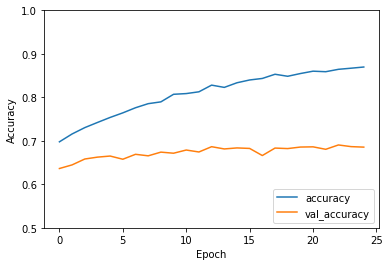

In [41]:
if not load_cnn1_model:
    #history only available after calling model.fit()
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

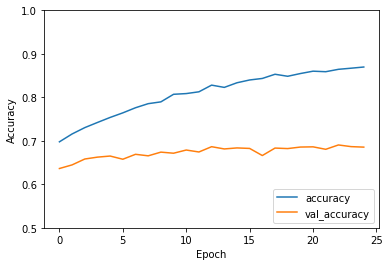

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [43]:
cnn_results = model_metrics_cnn(model, x_test, y_test)
all_results['CNN'] = cnn_results
cnn_results

{'Accuracy': 0.6934,
 'Precision': 0.7383957,
 'Recall': 0.6554,
 'F1': 0.6944267509828356,
 'AUC': 0.9416767}

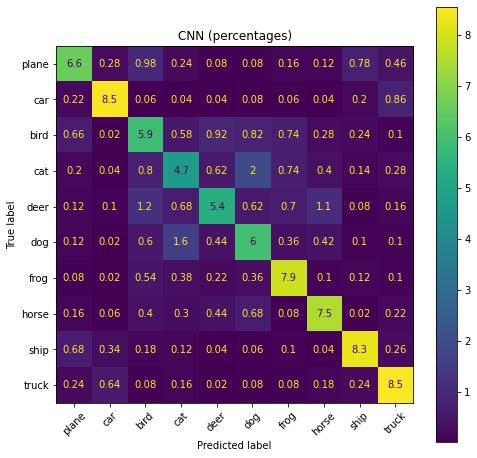

In [45]:
clf_cm(model, x_test, y_test, 'CNN')

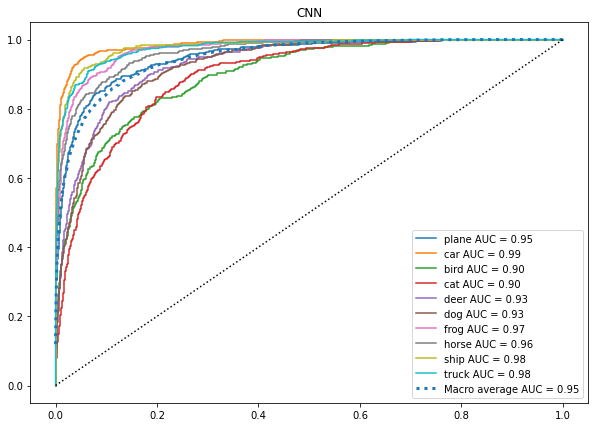

In [46]:
multiclass_roc_plot(y_test, model.predict(x_test), "CNN")

In [47]:
# Create classifier wrappers for trained models
keras_classifier = KerasClassifier(model=model, clip_values=(0, 1))
logreg_classifier = SklearnClassifier(model=lr_model, clip_values=(0, 1))
#svc_classifier = SklearnClassifier(model=svc_model, clip_values=(min_, max_))

#train classifiers 
logreg_classifier.fit(x_train_sk, y_train)
#svc_classifier.fit(x_train, y_train)
keras_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

C:\Users\mdsco\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 861us/sample - loss: 0.6290 - accuracy: 0.8098 - auc: 0.9744 - precision: 0.8547 - recall: 0.7612
Epoch 2/10
20000/20000 [==============================] - 17s 865us/sample - loss: 0.5617 - accuracy: 0.8270 - auc: 0.9789 - precision: 0.8738 - recall: 0.7779
Epoch 3/10
20000/20000 [==============================] - 17s 867us/sample - loss: 0.5324 - accuracy: 0.8335 - auc: 0.9810 - precision: 0.8772 - recall: 0.7897
Epoch 4/10
20000/20000 [==============================] - 17s 872us/sample - loss: 0.5087 - accuracy: 0.8404 - auc: 0.9823 - precision: 0.8832 - recall: 0.7977
Epoch 5/10
20000/20000 [==============================] - 18s 877us/sample - loss: 0.4908 - accuracy: 0.8413 - auc: 0.9837 - precision: 0.8841 - recall: 0.8000
Epoch 6/10
20000/20000 [==============================] - 17s 869us/sample - loss: 0.4751 - accuracy: 0.8457 - auc: 0.9848 - precision: 0.8864 - recall: 0.8054
Epoch 7/10
20000/

In [53]:
# DeepFool attack for neural networks
from art.attacks.evasion import DeepFool

load_cnn_df_images = False
if load_cnn_df_images:
    x_test_df_cnn = load_images('CNN1-DF')
else:
    # Craft adversarial samples with DeepFool
    print("Create DeepFool attack samples")
    min_ = 0
    max_= 1
    keras_classifier = KerasClassifier(model=model, clip_values=(min_, max_))
    df_cnn_attack = DeepFool(keras_classifier, epsilon=1.0e-4)
    x_test_df_cnn = df_cnn_attack.generate(x_test)
    save_images(x_test_df_cnn, 'CNN1-DF')    

Create DeepFool attack samples


DeepFool:   0%|          | 0/5000 [00:00<?, ?it/s]

Saving CNN1-DF-images.pkl


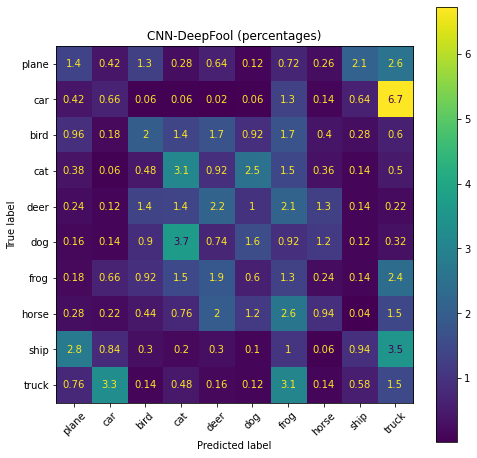

In [54]:
clf_cm(model, x_test_df_cnn, y_test, 'CNN-DeepFool')

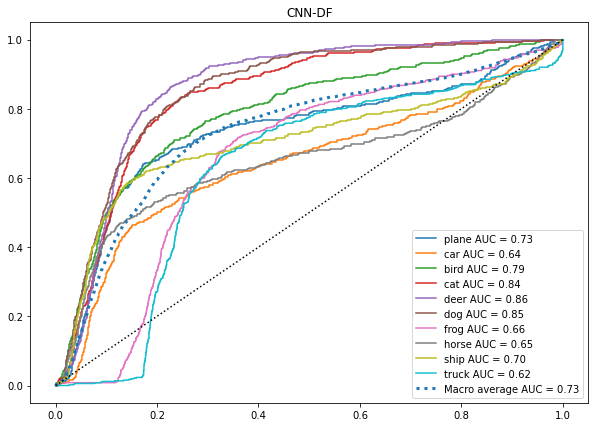

In [55]:
multiclass_roc_plot(y_test, model.predict(x_test_df_cnn), "CNN-DF")

In [56]:
# Compute and save metrics for CNN with DeepFool attack
cnn_df_results = model_metrics_cnn(model, x_test_df_cnn, y_test)
all_results['CNN-DF'] = cnn_df_results
cnn_df_results

{'Accuracy': 0.156,
 'Precision': 0.084540114,
 'Recall': 0.0432,
 'F1': 0.057180675205469156,
 'AUC': 0.7391422}

In [57]:
display_img(9, x_test_df)

NameError: name 'x_test_df' is not defined

In [58]:
#Fast gradient method on neural network
from art.attacks.evasion import FastGradientMethod

attack = FastGradientMethod(estimator=keras_classifier, eps=0.1)
x_test_fgm = attack.generate(x=x_test)
preds = np.argmax(model.predict(x_test_fgm), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  17.32


In [59]:
from art.attacks.evasion import FastGradientMethod
#fast gradient method on logistic regression
attack = FastGradientMethod(estimator=logreg_classifier, eps=0.1)
x_test_fgm_sk = attack.generate(x=x_test_sk)
preds = lr_model.predict(x_test_fgm_sk)
acc = lr_model.score(x_test_fgm_sk, y_test_sk)
print("Accuracy on adversarial samples: ", (acc * 100))

Accuracy on adversarial samples:  18.5


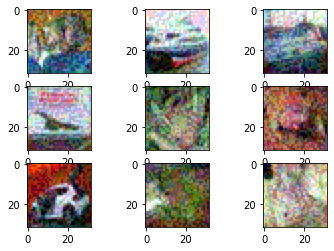

In [60]:
display_img(9, x_test_fgm_sk.reshape(x_test_fgm_sk.shape[0], 32, 32, 3))

In [62]:
from art.attacks.evasion import HopSkipJump
print("Create HopSkipJump attack")
load_cnn_hsj_images = False
if load_cnn_hsj_images:
    x_test_hsj_cnn = load_images('CNN1-HSJ')
else:
    hsj_cnn_crafter = HopSkipJump(keras_classifier, max_iter=20, max_eval=100,init_eval=25)
    x_test_hsj_cnn = hsj_cnn_crafter.generate(x_test)
    save_images(x_test_hsj_cnn, 'CNN-HSJ')

Create HopSkipJump attack


HopSkipJump:   0%|          | 0/5000 [00:00<?, ?it/s]

Saving CNN-HSJ-images.pkl


In [63]:
# Compute and save metrics for CNN with DeepFool attack
cnn_hsj_results = model_metrics_cnn(model, x_test_hsj_cnn, y_test)
all_results['CNN-HSJ'] = cnn_hsj_results
cnn_hsj_results

{'Accuracy': 0.1794,
 'Precision': 0.18881822,
 'Recall': 0.1128,
 'F1': 0.14122950071730775,
 'AUC': 0.8817299}

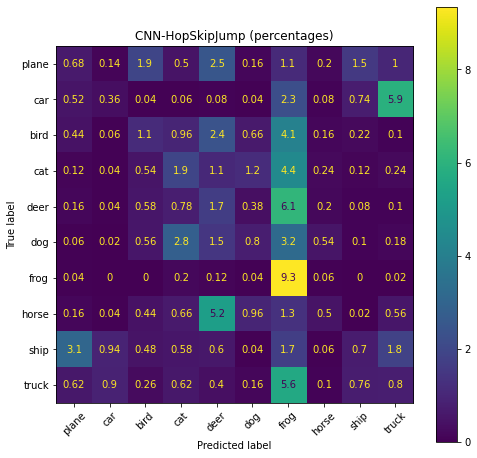

In [64]:
clf_cm(model, x_test_hsj_cnn, y_test, 'CNN-HopSkipJump')

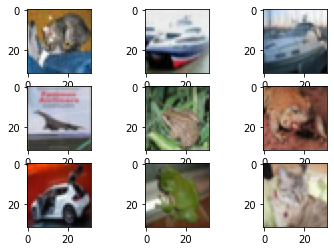

In [65]:
display_img(9,x_test_hsj_cnn)

In [66]:
# Try DeepFool attack on LogisticRegression model
load_lr_df_images = False
if load_lr_df_images:
    x_test_df_lr = load_images('LR-DF')
else:
    lr_df_clf = SklearnClassifier(model=lr_clf, clip_values=(np.min(x_test_run), np.max(x_test_run)))
    attack = DeepFool(lr_df_clf, epsilon=1.0e-5)
    x_test_df_lr = attack.generate(x=x_test_run)
    save_images(x_test_df_lr, 'LR-DF')

NameError: name 'x_test_run' is not defined

In [ ]:
# Accumulate metrics
lr_df_results = model_metrics(lr_clf, x_test_df_lr, y_test_sk)
all_results['LogisticRegression-DF'] = lr_df_results
lr_df_results

In [ ]:
clf_cm(lr_clf, x_test_df_lr, y_test_sk, 'LogisticRegression - DeepFool')

In [ ]:
multiclass_roc_plot(y_test, lr_clf.predict_proba(x_test_df_lr), "LR-DF")

In [ ]:
# Try HopSkipJump attack on LogisticRegression model
load_lr_hsj_images = False
if load_lr_hsj_images:
    x_test_hsj_lr = load_images('LR-HSJ')
else:
    lr_hsj_clf = SklearnClassifier(model=lr_clf, clip_values=(np.min(x_test_run), np.max(x_test_run)))
    lr_hsj_attack = HopSkipJump(lr_hsj_clf, max_eval=500, max_iter=25)
    x_test_hsj_lr = lr_hsj_attack.generate(x=x_test_run)
    save_images(x_test_hsj_lr, 'LR-HSJ')